[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0736 - val_loss: 0.0011
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0073 - val_loss: 0.0014
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_l

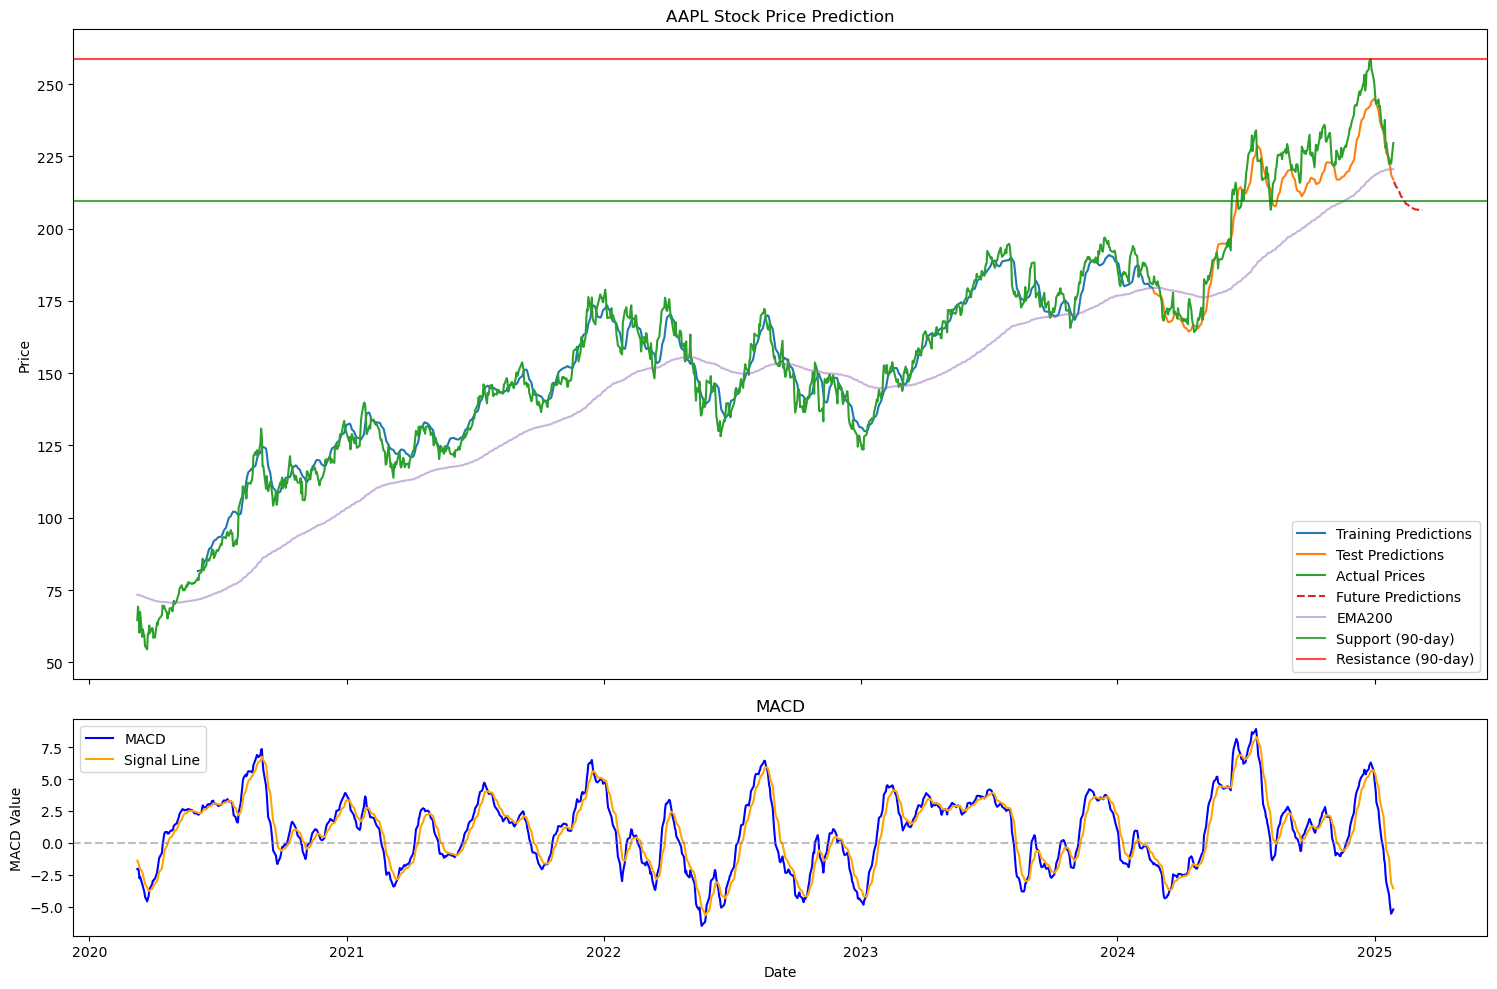

Training RMSE: 4.33
Testing RMSE: 8.11
Support Level (90-day window): $209.68
Resistance Level (90-day window): $258.74
Future Predictions for next 30 days:
2025-01-28: $216.27
2025-01-29: $215.68
2025-01-30: $215.11
2025-01-31: $214.49
2025-02-03: $213.83
2025-02-04: $213.15
2025-02-05: $212.47
2025-02-06: $211.79
2025-02-07: $211.15
2025-02-10: $210.54
2025-02-11: $209.98
2025-02-12: $209.47
2025-02-13: $209.01
2025-02-14: $208.60
2025-02-17: $208.24
2025-02-18: $207.92
2025-02-19: $207.64
2025-02-20: $207.41
2025-02-21: $207.21
2025-02-24: $207.04
2025-02-25: $206.90
2025-02-26: $206.79
2025-02-27: $206.70
2025-02-28: $206.63
2025-03-03: $206.57
2025-03-04: $206.53
2025-03-05: $206.50
2025-03-06: $206.47
2025-03-07: $206.46
2025-03-10: $206.45


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# 1. Get stock data with technical indicators
def get_stock_data(ticker, start_date, end_date, sr_window=200):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    df = pd.DataFrame()
    df['Close'] = stock_data['Close']
    df['Volume'] = stock_data['Volume']
    df['EMA10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()
    df['EMA20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
    df['EMA200'] = stock_data['Close'].ewm(span=200, adjust=False).mean()
    
    # MACD
    ema12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['BB_Middle'] = stock_data['Close'].rolling(window=20).mean()
    df['BB_Std'] = stock_data['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    
    # Support/Resistance with custom window
    df['Support'] = stock_data['Close'].rolling(window=sr_window, center=True).min()
    df['Resistance'] = stock_data['Close'].rolling(window=sr_window, center=True).max()
    
    return df.dropna()

# 2. Prepare the data with multiple features
def prepare_data(data, look_back=60):
    features = ['Close', 'Volume', 'EMA10', 'EMA20', 'EMA200', 'MACD', 'MACD_Signal', 
                'BB_Upper', 'BB_Lower', 'Support', 'Resistance']
    scaled_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data[features])
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predict Close price
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[0:train_size], X[train_size:]
    y_train, y_test = y[0:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, MinMaxScaler(feature_range=(0, 1)).fit(data[features]), scaled_data, features

# 3. Build the LSTM model
def create_model(look_back=60, n_features=11):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 4. Predict future prices
def predict_future(model, last_sequence, scaler, days_to_predict, look_back, n_features):
    future_predictions = []
    current_sequence = last_sequence.reshape((1, look_back, n_features))
    
    for _ in range(days_to_predict):
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        new_row = np.zeros(n_features)
        new_row[0] = next_pred[0, 0]
        new_row[1:] = current_sequence[0, -1, 1:]
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = new_row
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_scaled = np.hstack([future_predictions, np.tile(current_sequence[0, -1, 1:], (days_to_predict, 1))])
    future_predictions = scaler.inverse_transform(future_scaled)[:, 0]
    return future_predictions

# 5. Main execution
def main(sr_window=90):  # Added sr_window parameter with default value
    # Parameters
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2025-04-01'
    look_back = 60
    days_to_predict = 30
    n_features = 11
    
    # Get and prepare data with custom support/resistance window
    stock_data = get_stock_data(ticker, start_date, end_date, sr_window)
    X_train, X_test, y_train, y_test, scaler, scaled_data, features = prepare_data(stock_data, look_back)
    
    # Create and train model
    model = create_model(look_back, n_features)
    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)
    
    # Make predictions on historical data
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Inverse transform historical predictions
    train_predict = scaler.inverse_transform(np.hstack([train_predict, np.zeros((train_predict.shape[0], n_features-1))]))[:, 0]
    y_train_inv = scaler.inverse_transform(np.hstack([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], n_features-1))]))[:, 0]
    test_predict = scaler.inverse_transform(np.hstack([test_predict, np.zeros((test_predict.shape[0], n_features-1))]))[:, 0]
    y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], n_features-1))]))[:, 0]
    
    # Predict future prices
    last_sequence = scaled_data[-look_back:]
    future_predictions = predict_future(model, last_sequence, scaler, days_to_predict, look_back, n_features)
    
    # Generate future dates
    last_date = stock_data.index[-1]
    future_dates = pd.date_range(start=last_date, periods=days_to_predict + 1, freq='B')[1:]
    
    # Get recent support and resistance levels
    support_level = stock_data['Support'].iloc[-1]
    resistance_level = stock_data['Resistance'].iloc[-1]
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Price plot
    ax1.plot(stock_data.index[look_back:len(train_predict)+look_back], train_predict, 
             label='Training Predictions')
    ax1.plot(stock_data.index[len(train_predict)+look_back:], test_predict, 
             label='Test Predictions')
    ax1.plot(stock_data.index, stock_data['Close'], label='Actual Prices')
    ax1.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
    ax1.plot(stock_data.index, stock_data['EMA200'], label='EMA200', alpha=0.5)
    
    # Plot horizontal support and resistance
    ax1.axhline(y=support_level, color='green', linestyle='-', alpha=0.7, label=f'Support ({sr_window}-day)')
    ax1.axhline(y=resistance_level, color='red', linestyle='-', alpha=0.7, label=f'Resistance ({sr_window}-day)')
    
    ax1.set_title(f'{ticker} Stock Price Prediction')
    ax1.set_ylabel('Price')
    ax1.legend()
    
    # MACD plot
    ax2.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
    ax2.plot(stock_data.index, stock_data['MACD_Signal'], label='Signal Line', color='orange')
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title('MACD')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train_inv) ** 2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_inv) ** 2))
    print(f'Training RMSE: {train_rmse:.2f}')
    print(f'Testing RMSE: {test_rmse:.2f}')
    print(f'Support Level ({sr_window}-day window): ${support_level:.2f}')
    print(f'Resistance Level ({sr_window}-day window): ${resistance_level:.2f}')
    print(f'Future Predictions for next {days_to_predict} days:')
    for date, price in zip(future_dates, future_predictions):
        print(f'{date.strftime("%Y-%m-%d")}: ${price:.2f}')

if __name__ == "__main__":
    # You can change the sr_window value here
    main(sr_window=90)  # Example: 90-day window; try 30, 60, 200, etc.